# Fertility in Developed and Developing Countries
---

### Introduction

In this project we will compare the fertility in developed vs developing countries. Using UN data we aim to draw conclusions based on a country's development and their fertility, contraceptive use, and infant survival rates. This will allow for an understanding of how human development may influence a society's perspective on sex and birth.

---
 

### Importing and Cleaning Fertility Data

In [10]:
# Dependencies
import time
import hvplot.pandas
import pandas as pd
import xml.etree.ElementTree as ET
import geoviews as gv
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [11]:
# Read in data
fertility_df = pd.read_excel('data/fertility.xlsx')

# Clean up data
fertility_df = fertility_df.iloc[1:]

# Renaming for readability
fertility_df.rename(columns={'Reference': 'Year'}, inplace=True)
fertility_df.rename(columns={'Age-specific fertility rates': 'Age: 15-19'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 7': 'Fertility at age: 20-24'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 8': 'Fertility at age: 25-29'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 9': 'Fertility at age: 30-34'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 10': 'Fertility at age: 35-39'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 11': 'Fertility at age: 40-44'}, inplace=True)
fertility_df.rename(columns={'Unnamed: 12': 'Fertility at age: 45-49'}, inplace=True)

# Drop uneccessary columns
fertility_df.drop(columns=['Unnamed: 4'], inplace=True)
fertility_df.drop(columns=['Source type'], inplace=True)
fertility_df.drop(columns=['Source'], inplace=True)
fertility_df.drop(columns=['Survey name'], inplace=True)
fertility_df.drop(columns=['Note on country or population'], inplace=True)
fertility_df.drop(columns=['Note on age'], inplace=True)
fertility_df.drop(columns=['Note on methods'], inplace=True)
fertility_df.drop(columns=['Note on population data used in denominator'], inplace=True)

# Write to csv
fertility_df.to_csv('data/fertility_clean.csv', index=False)

# Show dataframe
fertility_df


,Country,ISO code,Period,Reference,Total fertility,Age: 15-19,Fertility at age: 20-24,Fertility at age: 25-29,Fertility at age: 30-34,Fertility at age: 35-39,Fertility at age: 40-44,Fertility at age: 45-49,Mean age at childbearing
1,Afghanistan,4.0,Around 1970,1973,8.21,168,359,355,307,235,137,81,30
2,Afghanistan,4.0,..,1979,7.11,105,260,309,301,262,185,..,30.7
3,Afghanistan,4.0,Around 2005,2003,7.52,146,333,350,289,217,143,..,30.1
4,Afghanistan,4.0,Latest,2009,5.11,80,257,262,209,128,60,26,29.1
5,Albania,8.0,Around 1970,1970,5.16,39,275,266,214,146,69,22,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,Zimbabwe,716.0,Around 1970,1969,6.74,79,272,304,257,218,145,73,31.2
1070,Zimbabwe,716.0,Around 1985,1987,5.42,102,251,250,212,158,80,32,29.5
1071,Zimbabwe,716.0,Around 1995,1998,3.98,112,199,180,135,108,46,15,28.3
1072,Zimbabwe,716.0,Around 2005,2004,3.8,99,205,172,144,86,42,13,28.1


### Importing and Cleaning GDP (Development) Data

In [12]:
# Read in XML data
tree = ET.parse('data/gdp_per_capita.xml')
root = tree.getroot()

# Iterate through and add xml records
data = []

for record in root.findall('.//record'):
    record_data = {}
    for field in record.findall('field'):
        name = field.get('name')
        value = field.text if field.text else None
        record_data[name] = value
    data.append(record_data)

# Create DataFrame from data
gdp_pc_df = pd.DataFrame(data)

# Clean up data
gdp_pc_df.drop(columns=['Value Footnotes'], inplace=True)

# Remove non-country areas
gdp_pc_df.rename(columns={'Country or Area': 'Country'}, inplace=True)
gdp_pc_df = gdp_pc_df[~gdp_pc_df['Country'].isin([
    'Africa Eastern and Southern', 'Africa Western and Central', "Arab World", 
    "Caribbean small states", "Central Europe and the Baltics", "Early-demographic dividend", 
    "East Asia & Pacific", "East Asia & Pacific (excluding high income)", 
    "East Asia & Pacific (IDA & IBRD)", "Europe & Central Asia", 
    "Europe & Central Asia (excluding high income)", "Euro area", 
    "Europe & Central Asia (IDA & IBRD)", "European Union", 
    "Fragile and conflict affected situations", "Heavily indebted poor countries (HIPC)", 
    "High income", "IBRD only", "IDA & IBRD total", "IDA blend", "IDA only", 
    "IDA total", "Late-demographic dividend", "Latin America & Caribbean", 
    "Latin America & Caribbean (excluding high income)", 
    "Latin America & Caribbean (IDA & IBRD)", "Least developed countries: UN classification", 
    "Low & middle income", "Low income", "Lower middle income", 
    "Middle East & North Africa", "Middle East & North Africa (excluding high income)", 
    "Middle East & North Africa (IDA & IBRD)", "Middle income", 
    "North America", "OECD members", "Other small states", 
    "Pacific island small states", "Post-demographic dividend", 
    "Pre-demographic dividend", "Small states", "South Asia", 
    "South Asia (IDA & IBRD)", "Sub-Saharan Africa", 
    "Sub-Saharan Africa (excluding high income)", "Sub-Saharan Africa (IDA & IBRD)", 
    "Upper middle income", "World"])]

# Get development status (> or < 12000 USD)
gdp_pc_df['Value'] = pd.to_numeric(gdp_pc_df['Value'], errors='coerce')
gdp_pc_df['Development'] = gdp_pc_df['Value'].apply(lambda x: 'Developed' if x > 12000 else 'Developing')

# Sort the DataFrame by Country and Year
gdp_pc_df = gdp_pc_df.sort_values(by=['Country', 'Year'])

# Find best year for each country (2012 oreferred, else under 2012, then if need be over 2012)
gdp_pc_df['Year'] = pd.to_numeric(gdp_pc_df['Year'], errors='coerce')
df_pre_2012 = gdp_pc_df[gdp_pc_df['Year'] <= 2012].sort_values(by=['Country', 'Year'], ascending=[True, False])
df_post_2012 = gdp_pc_df[gdp_pc_df['Year'] > 2012].sort_values(by=['Country', 'Year'], ascending=[True, True])
df_pre_2012_closest = df_pre_2012.groupby('Country').first().reset_index()
df_post_2012_closest = df_post_2012[~df_post_2012['Country'].isin(df_pre_2012_closest['Country'])].groupby('Country').first().reset_index()
gdp_pc_df = pd.concat([df_pre_2012_closest, df_post_2012_closest], ignore_index=True)


# Write to CSV
gdp_pc_df.to_csv('data/gdp_clean.csv', index=False)

gdp_pc_df



,Country,Year,Value,Development
0,Afghanistan,2012,1958.447627,Developing
1,Albania,2012,10526.250106,Developing
2,Algeria,2012,13347.362795,Developed
3,Angola,2012,7389.314960,Developing
4,Antigua and Barbuda,2012,20208.939288,Developed
...,...,...,...,...
193,Yemen,2012,3258.192678,Developing
194,Zambia,2012,3357.738371,Developing
195,Zimbabwe,2012,2349.028207,Developing
196,Djibouti,2013,3730.366512,Developing


### Merging Fertility and Development Data

In [13]:
# Get average fertility in each country
fertility_df['Total fertility'] = pd.to_numeric(fertility_df['Total fertility'], errors='coerce')
avg_fertility_df = fertility_df.groupby(['Country'], as_index=False).agg({'Total fertility': 'mean'})

# Match names for merging
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Bolivia (Plurinational State of)', 'Bolivia')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Czech Republic', 'Czechia')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Democratic Republic of the Congo', 'Congo DRC')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Iran (Islamic Republic of)', 'Iran')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Lao People\'s Democratic Republic', 'Laos')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('The former Yugoslav Republic of Macedonia', 'North Macedonia')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Russian Federation', 'Russia')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Swaziland', 'Eswatini')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Republic of Korea', 'South Korea')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('United Republic of Tanzania', 'Tanzania')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('United States of America', 'United States')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
avg_fertility_df['Country'] = avg_fertility_df['Country'].replace('Viet Nam', 'Vietnam')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('The Bahamas', 'Bahamas')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('CÃ´te d\'Ivoire', 'Côte d\'Ivoire')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Dem. Rep. Congo', 'Congo DRC')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('The Gambia', 'Gambia')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Kyrgyz Republic', 'Kyrgyzstan')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Lao PDR', 'Laos')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('St. Lucia', 'Saint Lucia')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('St. Vincent and the Grenadines', 'Saint Vincent and the Grenadines')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Slovak Republic', 'Slovakia')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Korea', 'South Korea')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('TÃ¼rkiye', 'Turkey')
gdp_pc_df['Country'] = gdp_pc_df['Country'].replace('Viet Nam', 'Vietnam')

# Merge with GDP
gdp_fertility_df = pd.merge(avg_fertility_df, gdp_pc_df, on="Country", how="inner")
gdp_fertility_df.rename(columns={'Total fertility': 'Fertility'}, inplace=True)

gdp_fertility_df


,Country,Fertility,Year,Value,Development
0,Afghanistan,6.9875,2012,1958.447627,Developing
1,Albania,2.8580,2012,10526.250106,Developing
2,Algeria,4.5420,2012,13347.362795,Developed
3,Angola,6.4400,2012,7389.314960,Developing
4,Antigua and Barbuda,2.2220,2012,20208.939288,Developed
...,...,...,...,...,...
182,Venezuela,3.4800,2011,17402.275659,Developed
183,Vietnam,3.4240,2012,6364.978023,Developing
184,Yemen,6.7980,2012,3258.192678,Developing
185,Zambia,6.2440,2012,3357.738371,Developing


### Importing and cleaning Country Centroid Coordinate Data

In [14]:
# Read in country data
countries_df = pd.read_csv('data/countries.csv')

# Clean the data
countries_df.rename(columns={'COUNTRY': 'Country'}, inplace=True)
countries_df.drop(columns=['ISO'], inplace=True)
countries_df.drop(columns=['COUNTRYAFF'], inplace=True)
countries_df.drop(columns=['AFF_ISO'], inplace=True)
countries_df['Country'] = countries_df['Country'].replace('Czech Republic', 'Czechia')
countries_df['Country'] = countries_df['Country'].replace('Russian Federation', 'Russia')

#countries_df
# Merge with GDP
gdp_fertility_df = pd.merge(gdp_fertility_df, countries_df, on="Country", how="inner")

# Write to csv
gdp_fertility_df.to_csv('data/dev_fert_latlng.csv', index=False)

gdp_fertility_df

,Country,Fertility,Year,Value,Development,longitude,latitude
0,Afghanistan,6.9875,2012,1958.447627,Developing,66.592161,34.134026
1,Albania,2.8580,2012,10526.250106,Developing,20.061083,41.141659
2,Algeria,4.5420,2012,13347.362795,Developed,2.655846,28.350970
3,Angola,6.4400,2012,7389.314960,Developing,17.651769,-12.167424
4,Antigua and Barbuda,2.2220,2012,20208.939288,Developed,-61.785308,17.071468
...,...,...,...,...,...,...,...
182,Venezuela,3.4800,2011,17402.275659,Developed,-66.364921,7.148325
183,Vietnam,3.4240,2012,6364.978023,Developing,105.913388,16.517347
184,Yemen,6.7980,2012,3258.192678,Developing,47.468158,16.001393
185,Zambia,6.2440,2012,3357.738371,Developing,27.755214,-13.162833


# How do fertility rates differ in developed vs developing countries?

# Map of Fertility in Developed and Developing Countries
 

In [15]:
# Multiply Fertility by 100 to control marker size
gdp_fertility_df['Fertility_Size'] = gdp_fertility_df['Fertility'] * 10

# Map coloring
color_map = {
    'Developed': 'blue',
    'Developing': 'orange'
}

# Configure the map plot
tiles = gv.tile_sources.OSM()

map_plot = tiles * gdp_fertility_df.hvplot.points(
    'longitude', 'latitude',
    geo=True,
    size='Fertility_Size',
    color=gdp_fertility_df['Development'].map(color_map),
    title='Fertility in Developed and Developing Countries',
    hover_cols=['Country', 'Development', 'Fertility'],
    frame_height=400,
    frame_width=600
)

# Display the map
map_plot


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (_color,Fertility_Size,Country,Development,Fertility)

# Satter Plot of Fertility in Developed and Developing Countries
 

In [16]:
# Define a function to create Linear Regression plots
def plot_lin_reg(x, y, x_label, y_label, title, development="Developed"):
    if(development == "Developed"):
        s_color = "blue"
    elif(development == "Developing"):
        s_color = "orange"
    # Perform linear regression
    (slope, intercept, r_value, p_value, std_err) = linregress(x, y)
    regress_values = slope * x + intercept

    # make plot and line
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color=s_color, edgecolor='black', linewidths=1, marker='o', alpha=0.75)
    plt.plot(x, regress_values, color="red", label=f"Linear Reg (slope={slope:.2f})")
    
    # Incorporate the other graph properties
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True)
    plt.show()

# Get only developed
deved_df = gdp_fertility_df[gdp_fertility_df['Development'] == 'Developed']

# Get only developing
not_deved_df = gdp_fertility_df[gdp_fertility_df['Development'] == 'Developing']


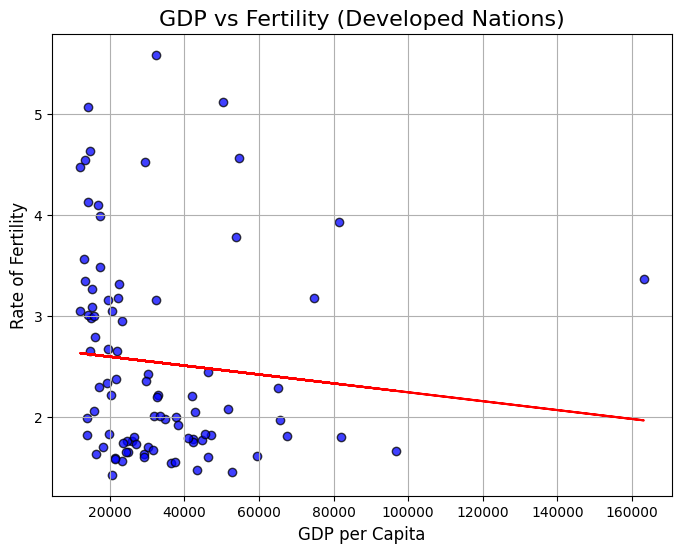

In [17]:
plot_lin_reg(deved_df["Value"], deved_df["Fertility"], "GDP per Capita", "Rate of Fertility", "GDP vs Fertility (Developed Nations)", "Developed")

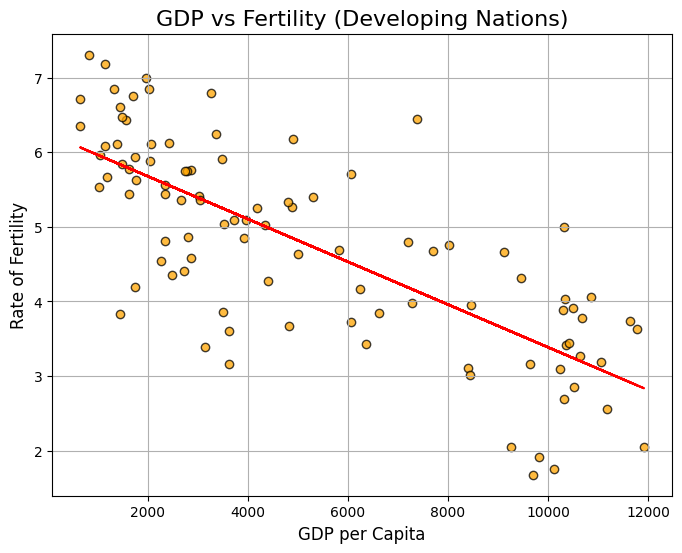

In [18]:
plot_lin_reg(not_deved_df["Value"], not_deved_df["Fertility"], "GDP per Capita", "Rate of Fertility", "GDP vs Fertility (Developing Nations)", "Developing")

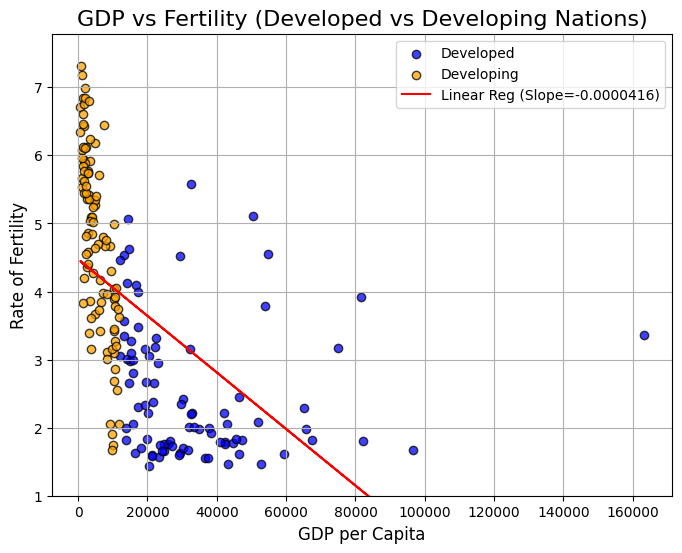

In [19]:
# Perform linear regression
slope, intercept, _, _, _ = linregress(gdp_fertility_df["Value"], gdp_fertility_df["Fertility"])
regress_values = slope * gdp_fertility_df["Value"] + intercept

# make plot and line
plt.figure(figsize=(8, 6))
    
# Scatter for developed (blue)
developed = gdp_fertility_df[gdp_fertility_df['Development'] == 'Developed']
plt.scatter(developed["Value"], developed["Fertility"], color="blue", edgecolor='black', 
linewidths=1, marker='o', alpha=0.75, label='Developed')
    
# Scatter for developing (orange)
developing = gdp_fertility_df[gdp_fertility_df['Development'] == 'Developing']
plt.scatter(developing["Value"], developing["Fertility"], color="orange", edgecolor='black', 
            linewidths=1, marker='o', alpha=0.75, label='Developing')
    
plt.plot(gdp_fertility_df["Value"], regress_values, color="red", label=f"Linear Reg (Slope={slope:.7f})")
    
# Incorporate the other graph properties
plt.ylim(1)
plt.title("GDP vs Fertility (Developed vs Developing Nations)", fontsize=16)
plt.xlabel("GDP per Capita", fontsize=12)
plt.ylabel("Rate of Fertility", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# 
---

### How do fertility rates differ in developed vs developing countries? - Analysis

There is a clear correlation in both developed and developing countries where there is an increase in GDP per Capita, you see a decrease in the rate of fertility. That is to say, in general, that citizens of more developed and wealthy countries tend to have fewer children than citizens of less developed and less wealthy countries. The difference in fertility is most apparent amongst developing countries. Countries with GDP per capitas near the development boundary of $12,000 USD, have fertility rates (~2 to 4) dramatically lower than those at the very bottom of the global GDP valuations (~5 to 7).

---
 